<a href="https://colab.research.google.com/github/sahug/ds-nlp/blob/main/NLP%20-%20Session%2021%20-%20LSTM%20Disaster%20Tweet%20Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NLP - Session 21 - LSTM Disaster Tweet Classifier**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
test_ds = pd.read_csv("/content/test.csv")
train_ds = pd.read_csv("/content/train.csv")

In [3]:
train_ds.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


Text(0.5, 0, 'Non Disaster Tweets vs Disaster Tweets')

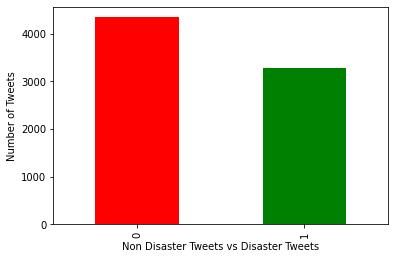

In [4]:
bars = train_ds.value_counts("target").plot(kind="bar", color=["red", "green"])
plt.ylabel("Number of Tweets")
plt.xlabel("Non Disaster Tweets vs Disaster Tweets")

In [5]:
#Remove URLs
def rem_URL(text):
  url = re.compile("https?://\S+|www\.\S+")
  return url.sub("", text)

#Remove Punctuation
def rem_punc(text):
  translator = str.maketrans("", "", string.punctuation)
  return text.translate(translator)

In [6]:
#Remove stopwords
nltk.download("stopwords")

stop = set(stopwords.words("english"))

def rem_stopwords(text):
  filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
  return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
def count_df(df):
  counter = Counter()

  for i in df:
    for w in i.split():
      counter[w] += 1

  return counter

In [8]:
# Applying different operations on the text
train_ds["text"] = train_ds.text.map(rem_URL)
train_ds["text"] = train_ds.text.map(rem_punc)
train_ds["text"] = train_ds.text.map(rem_stopwords)

Text(0, 0.5, 'Word Count')

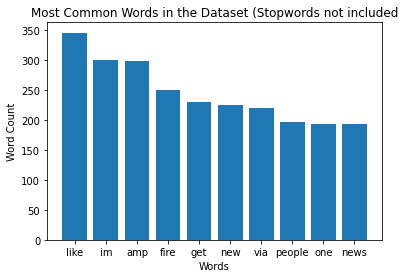

In [10]:
#Most Common Words Graphs
most_common_text = count_df(train_ds["text"]).most_common(10)
most_common_text_items, most_common_text_values = zip(*most_common_text)

plt.bar(most_common_text_items, most_common_text_values)
plt.title("Most Common Words in the Dataset (Stopwords not included)")
plt.xlabel("Words")
plt.ylabel("Word Count")

Text(0, 0.5, 'Word Count')

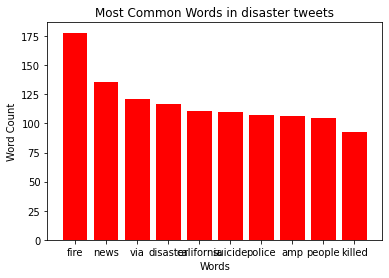

In [13]:
#Most Common Words Graphs
most_common_text_d = count_df(train_ds.loc[train_ds["target"]==True]["text"]).most_common(10)
most_common_text_d_items, most_common_text_d_values = zip(*most_common_text_d)

plt.bar(most_common_text_d_items, most_common_text_d_values, color='r')
plt.title("Most Common Words in disaster tweets")
plt.xlabel("Words")
plt.ylabel("Word Count")

Text(0, 0.5, 'Word Count')

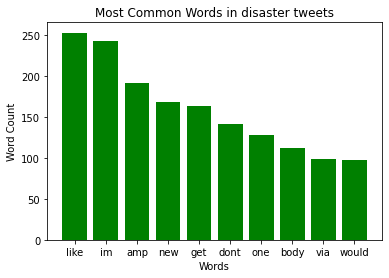

In [14]:
#Most Common Words Graphs
most_common_text_d = count_df(train_ds.loc[train_ds["target"]==False]["text"]).most_common(10)
most_common_text_d_items, most_common_text_d_values = zip(*most_common_text_d)

plt.bar(most_common_text_d_items, most_common_text_d_values, color='g')
plt.title("Most Common Words in disaster tweets")
plt.xlabel("Words")
plt.ylabel("Word Count")

In [15]:
#Get number of unique words
num_unique_words = len(count_df(train_ds["text"]))
num_unique_words

17971

In [16]:
#Setup data
train_size = int(train_ds.shape[0] * 0.8)

train_df = train_ds[:train_size]
val_df = train_ds[train_size:]

train_sentences = train_ds["text"].to_numpy()
train_labels = train_ds["target"].to_numpy()
val_sentences = val_df["text"].to_numpy()
val_labels = val_df["target"].to_numpy()

In [17]:
train_sentences.shape, val_sentences.shape

((7613,), (1523,))

In [19]:
#Tokenization
tokenizer = Tokenizer(num_words = num_unique_words)
tokenizer.fit_on_texts(train_sentences)

In [20]:
word_index = tokenizer.word_index

In [21]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)

In [22]:
#Padding sequences to make shapes of the arrays equal
MAX_LEN = 20

train_padded = pad_sequences(train_sequences, maxlen=MAX_LEN, padding="post", truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=MAX_LEN, padding="post", truncating="post")

train_padded.shape, val_padded.shape

((7613, 20), (1523, 20))

In [23]:
#Making Model
model = keras.models.Sequential([
        layers.Embedding(num_unique_words, 32, input_length=MAX_LEN),
        layers.LSTM(64, dropout=0.1),
        layers.Dense(1, activation="sigmoid")                  
])

In [26]:
#Compile Model
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(lr=0.01),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [27]:
model.fit(train_padded, train_labels, epochs=20, validation_data=(val_padded, val_labels))

Epoch 1/20
238/238 [==============================] - 12s 32ms/step - loss: 0.6410 - accuracy: 0.6352 - val_loss: 0.4400 - val_accuracy: 0.8418
Epoch 2/20
238/238 [==============================] - 7s 29ms/step - loss: 0.4009 - accuracy: 0.8382 - val_loss: 0.2103 - val_accuracy: 0.9409
Epoch 3/20
238/238 [==============================] - 8s 33ms/step - loss: 0.1969 - accuracy: 0.9316 - val_loss: 0.0991 - val_accuracy: 0.9691
Epoch 4/20
238/238 [==============================] - 4s 19ms/step - loss: 0.1107 - accuracy: 0.9623 - val_loss: 0.0695 - val_accuracy: 0.9750
Epoch 5/20
238/238 [==============================] - 4s 18ms/step - loss: 0.0689 - accuracy: 0.9756 - val_loss: 0.0362 - val_accuracy: 0.9856
Epoch 6/20
238/238 [==============================] - 4s 18ms/step - loss: 0.0560 - accuracy: 0.9775 - val_loss: 0.0304 - val_accuracy: 0.9869
Epoch 7/20
238/238 [==============================] - 4s 17ms/step - loss: 0.0422 - accuracy: 0.9808 - val_loss: 0.0244 - val_accuracy: 0.986

In [28]:
#Make Predictions
predictions = model.predict(train_padded)
predictions = [1 if p>0.5 else 0 for p in predictions]

In [29]:
print(train_sentences[10:20])
print(train_labels[10:20])
print(predictions[10:20])

['three people died heat wave far'
 'haha south tampa getting flooded hah wait second live south tampa gonna gonna fvck flooding'
 'raining flooding florida tampabay tampa 18 19 days ive lost count'
 'flood bago myanmar arrived bago'
 'damage school bus 80 multi car crash breaking' 'whats man' 'love fruits'
 'summer lovely' 'car fast' 'goooooooaaaaaal']
[1 1 1 1 1 0 0 0 0 0]
[1, 1, 1, 1, 1, 0, 0, 0, 1, 0]


In [30]:
#Generate Final Submission
#Manipulating the testing data to make it readable for the model

test_ds["text"] = test_ds.text.map(rem_URL)
test_ds["text"] = test_ds.text.map(rem_punc)
test_ds["text"] = test_ds.text.map(rem_stopwords)
text_sequences = tokenizer.texts_to_sequences(test_ds["text"])
text_padded = pad_sequences(text_sequences, maxlen=MAX_LEN, padding="post", truncating="post")

In [31]:
len(text_padded) == len(test_ds)

True

In [32]:
# Feeding the data!
predictions = np.round(model.predict(text_padded))
predictions = [0 if i == 1 else 1 for i in predictions]

submission = pd.DataFrame(test_ds['id'])
submission['target'] = predictions

len(submission) == len(text_padded) == len(test_ds)
submission.to_csv('Output.csv', index=False)